In [1]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [2]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(0)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):

#   reward for clearing list
    if not any(queues):
        return 25
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1
    
        
def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time < -9.9:
        waiting_time = -9.9

def generate_random_numbers():
    random_sum = random.uniform(0.8, 1.5)  # Generate a random sum between 0.8 and 1.0
    random_numbers = []
    
    
    for _ in range(2):
        random_value = round(random.uniform(0.0, random_sum), 2)  # Generate a random value between 0.0 and the remaining sum with a maximum of one decimal place
        random_numbers.append(random_value)
        random_sum -= random_value

    random_numbers.append(round(random_sum, 1))  # Append the remaining sum to the list with a maximum of one decimal place
    if random_numbers == [0.3,0.4,0.4]: # make sure final numbers dont appear in the training phase
        random_numbers = generate_random_numbers() 
    
    return random_numbers

In [3]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self, q1rate, q2rate, q3rate):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(10000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [q1rate, q2rate, q3rate]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
       # if action < 3 and len(self.queues[action]) > 0:
        #    self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        #append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            #add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        
        
        
        #UPDATING ENVIRONMENT
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
    
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        observationUpdate = []        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue\
            current_waiting_time = calc_mean_delay(current_queue)
            observationUpdate.append(current_waiting_time)       
            
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        waiting_times = discretize(observationUpdate)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
    
    def change_arrival_rates(self,q1,q2,q3):
        self.arrival_rate = [q1,q2,q3]
        
    def render(self):
        pass

In [4]:
env = TrafficGenerator(0.3,0.25,0.4)
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(10000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [56]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters


total_episodes = 1000
total_test_episodes = 50
max_steps = 100
learning_rate = 0.9
gamma = 0.6
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
def train_model(gamma, learning_rate):
    rewardstest = []
    # Hyperparameters
    total_episodes = 400
    total_test_episodes = 50
    max_steps = 100
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay_rate = 0.01
    for episode in range(total_episodes):
        arr_rates = generate_random_numbers()
        env.change_arrival_rates(arr_rates[0], arr_rates[1], arr_rates[2])
        state = env.reset()
        total_rewards = 0
        print("Episode ", episode,"/", total_episodes )
        for step in range(max_steps):
            exp_exp_tradeoff = random.uniform(0, 1)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state, :])
            else:
                action = env.action_space.sample()

            new_state, reward, done, info = env.step(action)
            total_rewards += reward
            #print(new_state)
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
            state = new_state
    #         print(reward)
            if done: 
                rewardstest.append(total_rewards)
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))
    return rewardstest

rewardstest = train_model(0.1,0.1)

Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  44 / 400
Episode  45 / 400
Episode  46 / 400
Episode  47 / 400
Episode  48 / 400
Episode  49 / 400
Episode  50 / 400
Episode  51 / 400
Episode  52 / 400
Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Ep

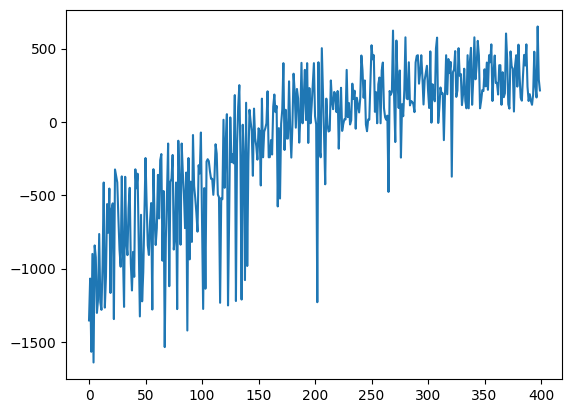

In [57]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n
plt.plot(rewardstest)
# Show the plot\n",
plt.show()


In [59]:
print(np.mean(rewardstest))


-118.8475


In [ ]:
# Play the Game
env = TrafficGenerator(0.3,0.25,0.4)

def test_model():
    rewards = []
    for episode in range(total_test_episodes):
        total_rewards = 0
        total_penalties = 0

        state = env.reset()
    #     print('='*40)
    #     print("[*] Episode", episode)
    #     print('='*40)

        for step in range(max_steps):
            env.render()
            action = np.argmax(qtable[state, :])
            state, reward, done, info = env.step(action)
    #         print(reward)
            """"
            if reward == -10:
                total_penalties += 1
            else:
                total_rewards += reward
            """
            total_rewards += reward
            #print("total time: {}", env.totaltime)
            if done:
                rewards.append(total_rewards)
                break
    print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

for i in range(10):
    test_model()
env.close()


In [63]:
from itertools import product
# Create a list to store the results
results = []

gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
learning_rate_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# Perform grid search
for gamma, learning_rate in product(gamma_values, learning_rate_values):
    action_size = env.action_space.n
    state_size = env.observation_space.n
    qtable = np.zeros((state_size, action_size))    
    # Training loop
    rewards = train_model(gamma, learning_rate)
    # Evaluate the learned Q-table using a test set or simulations
    average_reward = np.average(rewards)  # Implement your evaluation metric
    
    # Store the results
    results.append({'gamma': gamma, 'learning_rate': learning_rate, 'average_reward': average_reward})

# Find the optimal combination of gamma and learning rate
optimal_result = max(results, key=lambda x: x['average_reward'])
optimal_gamma = optimal_result['gamma']
optimal_learning_rate = optimal_result['learning_rate']

# Print the optimal values
print("Optimal Gamma:", optimal_gamma)
print("Optimal Learning Rate:", optimal_learning_rate)

Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  44 / 400
Episode  45 / 400
Episode  46 / 400
Episode  47 / 400
Episode  48 / 400
Episode  49 / 400
Episode  50 / 400
Episode  51 / 400
Episode  52 / 400
Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Ep

Episode  79 / 400
Episode  80 / 400
Episode  81 / 400
Episode  82 / 400
Episode  83 / 400
Episode  84 / 400
Episode  85 / 400
Episode  86 / 400
Episode  87 / 400
Episode  88 / 400
Episode  89 / 400
Episode  90 / 400
Episode  91 / 400
Episode  92 / 400
Episode  93 / 400
Episode  94 / 400
Episode  95 / 400
Episode  96 / 400
Episode  97 / 400
Episode  98 / 400
Episode  99 / 400
Episode  100 / 400
Episode  101 / 400
Episode  102 / 400
Episode  103 / 400
Episode  104 / 400
Episode  105 / 400
Episode  106 / 400
Episode  107 / 400
Episode  108 / 400
Episode  109 / 400
Episode  110 / 400
Episode  111 / 400
Episode  112 / 400
Episode  113 / 400
Episode  114 / 400
Episode  115 / 400
Episode  116 / 400
Episode  117 / 400
Episode  118 / 400
Episode  119 / 400
Episode  120 / 400
Episode  121 / 400
Episode  122 / 400
Episode  123 / 400
Episode  124 / 400
Episode  125 / 400
Episode  126 / 400
Episode  127 / 400
Episode  128 / 400
Episode  129 / 400
Episode  130 / 400
Episode  131 / 400
Episode  132 /

Episode  118 / 400
Episode  119 / 400
Episode  120 / 400
Episode  121 / 400
Episode  122 / 400
Episode  123 / 400
Episode  124 / 400
Episode  125 / 400
Episode  126 / 400
Episode  127 / 400
Episode  128 / 400
Episode  129 / 400
Episode  130 / 400
Episode  131 / 400
Episode  132 / 400
Episode  133 / 400
Episode  134 / 400
Episode  135 / 400
Episode  136 / 400
Episode  137 / 400
Episode  138 / 400
Episode  139 / 400
Episode  140 / 400
Episode  141 / 400
Episode  142 / 400
Episode  143 / 400
Episode  144 / 400
Episode  145 / 400
Episode  146 / 400
Episode  147 / 400
Episode  148 / 400
Episode  149 / 400
Episode  150 / 400
Episode  151 / 400
Episode  152 / 400
Episode  153 / 400
Episode  154 / 400
Episode  155 / 400
Episode  156 / 400
Episode  157 / 400
Episode  158 / 400
Episode  159 / 400
Episode  160 / 400
Episode  161 / 400
Episode  162 / 400
Episode  163 / 400
Episode  164 / 400
Episode  165 / 400
Episode  166 / 400
Episode  167 / 400
Episode  168 / 400
Episode  169 / 400
Episode  170

Episode  181 / 400
Episode  182 / 400
Episode  183 / 400
Episode  184 / 400
Episode  185 / 400
Episode  186 / 400
Episode  187 / 400
Episode  188 / 400
Episode  189 / 400
Episode  190 / 400
Episode  191 / 400
Episode  192 / 400
Episode  193 / 400
Episode  194 / 400
Episode  195 / 400
Episode  196 / 400
Episode  197 / 400
Episode  198 / 400
Episode  199 / 400
Episode  200 / 400
Episode  201 / 400
Episode  202 / 400
Episode  203 / 400
Episode  204 / 400
Episode  205 / 400
Episode  206 / 400
Episode  207 / 400
Episode  208 / 400
Episode  209 / 400
Episode  210 / 400
Episode  211 / 400
Episode  212 / 400
Episode  213 / 400
Episode  214 / 400
Episode  215 / 400
Episode  216 / 400
Episode  217 / 400
Episode  218 / 400
Episode  219 / 400
Episode  220 / 400
Episode  221 / 400
Episode  222 / 400
Episode  223 / 400
Episode  224 / 400
Episode  225 / 400
Episode  226 / 400
Episode  227 / 400
Episode  228 / 400
Episode  229 / 400
Episode  230 / 400
Episode  231 / 400
Episode  232 / 400
Episode  233

Episode  236 / 400
Episode  237 / 400
Episode  238 / 400
Episode  239 / 400
Episode  240 / 400
Episode  241 / 400
Episode  242 / 400
Episode  243 / 400
Episode  244 / 400
Episode  245 / 400
Episode  246 / 400
Episode  247 / 400
Episode  248 / 400
Episode  249 / 400
Episode  250 / 400
Episode  251 / 400
Episode  252 / 400
Episode  253 / 400
Episode  254 / 400
Episode  255 / 400
Episode  256 / 400
Episode  257 / 400
Episode  258 / 400
Episode  259 / 400
Episode  260 / 400
Episode  261 / 400
Episode  262 / 400
Episode  263 / 400
Episode  264 / 400
Episode  265 / 400
Episode  266 / 400
Episode  267 / 400
Episode  268 / 400
Episode  269 / 400
Episode  270 / 400
Episode  271 / 400
Episode  272 / 400
Episode  273 / 400
Episode  274 / 400
Episode  275 / 400
Episode  276 / 400
Episode  277 / 400
Episode  278 / 400
Episode  279 / 400
Episode  280 / 400
Episode  281 / 400
Episode  282 / 400
Episode  283 / 400
Episode  284 / 400
Episode  285 / 400
Episode  286 / 400
Episode  287 / 400
Episode  288

Episode  277 / 400
Episode  278 / 400
Episode  279 / 400
Episode  280 / 400
Episode  281 / 400
Episode  282 / 400
Episode  283 / 400
Episode  284 / 400
Episode  285 / 400
Episode  286 / 400
Episode  287 / 400
Episode  288 / 400
Episode  289 / 400
Episode  290 / 400
Episode  291 / 400
Episode  292 / 400
Episode  293 / 400
Episode  294 / 400
Episode  295 / 400
Episode  296 / 400
Episode  297 / 400
Episode  298 / 400
Episode  299 / 400
Episode  300 / 400
Episode  301 / 400
Episode  302 / 400
Episode  303 / 400
Episode  304 / 400
Episode  305 / 400
Episode  306 / 400
Episode  307 / 400
Episode  308 / 400
Episode  309 / 400
Episode  310 / 400
Episode  311 / 400
Episode  312 / 400
Episode  313 / 400
Episode  314 / 400
Episode  315 / 400
Episode  316 / 400
Episode  317 / 400
Episode  318 / 400
Episode  319 / 400
Episode  320 / 400
Episode  321 / 400
Episode  322 / 400
Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329

Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329 / 400
Episode  330 / 400
Episode  331 / 400
Episode  332 / 400
Episode  333 / 400
Episode  334 / 400
Episode  335 / 400
Episode  336 / 400
Episode  337 / 400
Episode  338 / 400
Episode  339 / 400
Episode  340 / 400
Episode  341 / 400
Episode  342 / 400
Episode  343 / 400
Episode  344 / 400
Episode  345 / 400
Episode  346 / 400
Episode  347 / 400
Episode  348 / 400
Episode  349 / 400
Episode  350 / 400
Episode  351 / 400
Episode  352 / 400
Episode  353 / 400
Episode  354 / 400
Episode  355 / 400
Episode  356 / 400
Episode  357 / 400
Episode  358 / 400
Episode  359 / 400
Episode  360 / 400
Episode  361 / 400
Episode  362 / 400
Episode  363 / 400
Episode  364 / 400
Episode  365 / 400
Episode  366 / 400
Episode  367 / 400
Episode  368 / 400
Episode  369 / 400
Episode  370 / 400
Episode  371 / 400
Episode  372 / 400
Episode  373 / 400
Episode  374 / 400
Episode  375

Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  44 / 400
Episode  45 / 400
Episode  46 / 400
Episode  47 / 400
Episode  48 / 400
Episode  49 / 400
Episode  50 / 400
Episode  51 / 400
Episode  52 / 400
Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Episode  56 / 400
Episode  57 / 400
Episode  58 / 400

Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Episode  56 / 400
Episode  57 / 400
Episode  58 / 400
Episode  59 / 400
Episode  60 / 400
Episode  61 / 400
Episode  62 / 400
Episode  63 / 400
Episode  64 / 400
Episode  65 / 400
Episode  66 / 400
Episode  67 / 400
Episode  68 / 400
Episode  69 / 400
Episode  70 / 400
Episode  71 / 400
Episode  72 / 400
Episode  73 / 400
Episode  74 / 400
Episode  75 / 400
Episode  76 / 400
Episode  77 / 400
Episode  78 / 400
Episode  79 / 400
Episode  80 / 400
Episode  81 / 400
Episode  82 / 400
Episode  83 / 400
Episode  84 / 400
Episode  85 / 400
Episode  86 / 400
Episode  87 / 400
Episode  88 / 400
Episode  89 / 400
Episode  90 / 400
Episode  91 / 400
Episode  92 / 400
Episode  93 / 400
Episode  94 / 400
Episode  95 / 400
Episode  96 / 400
Episode  97 / 400
Episode  98 / 400
Episode  99 / 400
Episode  100 / 400
Episode  101 / 400
Episode  102 / 400
Episode  103 / 400
Episode  104 / 400
Episode  105 / 400
Episode  106 / 400
Episode  107 / 400
Ep

Episode  123 / 400
Episode  124 / 400
Episode  125 / 400
Episode  126 / 400
Episode  127 / 400
Episode  128 / 400
Episode  129 / 400
Episode  130 / 400
Episode  131 / 400
Episode  132 / 400
Episode  133 / 400
Episode  134 / 400
Episode  135 / 400
Episode  136 / 400
Episode  137 / 400
Episode  138 / 400
Episode  139 / 400
Episode  140 / 400
Episode  141 / 400
Episode  142 / 400
Episode  143 / 400
Episode  144 / 400
Episode  145 / 400
Episode  146 / 400
Episode  147 / 400
Episode  148 / 400
Episode  149 / 400
Episode  150 / 400
Episode  151 / 400
Episode  152 / 400
Episode  153 / 400
Episode  154 / 400
Episode  155 / 400
Episode  156 / 400
Episode  157 / 400
Episode  158 / 400
Episode  159 / 400
Episode  160 / 400
Episode  161 / 400
Episode  162 / 400
Episode  163 / 400
Episode  164 / 400
Episode  165 / 400
Episode  166 / 400
Episode  167 / 400
Episode  168 / 400
Episode  169 / 400
Episode  170 / 400
Episode  171 / 400
Episode  172 / 400
Episode  173 / 400
Episode  174 / 400
Episode  175

Episode  162 / 400
Episode  163 / 400
Episode  164 / 400
Episode  165 / 400
Episode  166 / 400
Episode  167 / 400
Episode  168 / 400
Episode  169 / 400
Episode  170 / 400
Episode  171 / 400
Episode  172 / 400
Episode  173 / 400
Episode  174 / 400
Episode  175 / 400
Episode  176 / 400
Episode  177 / 400
Episode  178 / 400
Episode  179 / 400
Episode  180 / 400
Episode  181 / 400
Episode  182 / 400
Episode  183 / 400
Episode  184 / 400
Episode  185 / 400
Episode  186 / 400
Episode  187 / 400
Episode  188 / 400
Episode  189 / 400
Episode  190 / 400
Episode  191 / 400
Episode  192 / 400
Episode  193 / 400
Episode  194 / 400
Episode  195 / 400
Episode  196 / 400
Episode  197 / 400
Episode  198 / 400
Episode  199 / 400
Episode  200 / 400
Episode  201 / 400
Episode  202 / 400
Episode  203 / 400
Episode  204 / 400
Episode  205 / 400
Episode  206 / 400
Episode  207 / 400
Episode  208 / 400
Episode  209 / 400
Episode  210 / 400
Episode  211 / 400
Episode  212 / 400
Episode  213 / 400
Episode  214

Episode  219 / 400
Episode  220 / 400
Episode  221 / 400
Episode  222 / 400
Episode  223 / 400
Episode  224 / 400
Episode  225 / 400
Episode  226 / 400
Episode  227 / 400
Episode  228 / 400
Episode  229 / 400
Episode  230 / 400
Episode  231 / 400
Episode  232 / 400
Episode  233 / 400
Episode  234 / 400
Episode  235 / 400
Episode  236 / 400
Episode  237 / 400
Episode  238 / 400
Episode  239 / 400
Episode  240 / 400
Episode  241 / 400
Episode  242 / 400
Episode  243 / 400
Episode  244 / 400
Episode  245 / 400
Episode  246 / 400
Episode  247 / 400
Episode  248 / 400
Episode  249 / 400
Episode  250 / 400
Episode  251 / 400
Episode  252 / 400
Episode  253 / 400
Episode  254 / 400
Episode  255 / 400
Episode  256 / 400
Episode  257 / 400
Episode  258 / 400
Episode  259 / 400
Episode  260 / 400
Episode  261 / 400
Episode  262 / 400
Episode  263 / 400
Episode  264 / 400
Episode  265 / 400
Episode  266 / 400
Episode  267 / 400
Episode  268 / 400
Episode  269 / 400
Episode  270 / 400
Episode  271

Episode  263 / 400
Episode  264 / 400
Episode  265 / 400
Episode  266 / 400
Episode  267 / 400
Episode  268 / 400
Episode  269 / 400
Episode  270 / 400
Episode  271 / 400
Episode  272 / 400
Episode  273 / 400
Episode  274 / 400
Episode  275 / 400
Episode  276 / 400
Episode  277 / 400
Episode  278 / 400
Episode  279 / 400
Episode  280 / 400
Episode  281 / 400
Episode  282 / 400
Episode  283 / 400
Episode  284 / 400
Episode  285 / 400
Episode  286 / 400
Episode  287 / 400
Episode  288 / 400
Episode  289 / 400
Episode  290 / 400
Episode  291 / 400
Episode  292 / 400
Episode  293 / 400
Episode  294 / 400
Episode  295 / 400
Episode  296 / 400
Episode  297 / 400
Episode  298 / 400
Episode  299 / 400
Episode  300 / 400
Episode  301 / 400
Episode  302 / 400
Episode  303 / 400
Episode  304 / 400
Episode  305 / 400
Episode  306 / 400
Episode  307 / 400
Episode  308 / 400
Episode  309 / 400
Episode  310 / 400
Episode  311 / 400
Episode  312 / 400
Episode  313 / 400
Episode  314 / 400
Episode  315

Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329 / 400
Episode  330 / 400
Episode  331 / 400
Episode  332 / 400
Episode  333 / 400
Episode  334 / 400
Episode  335 / 400
Episode  336 / 400
Episode  337 / 400
Episode  338 / 400
Episode  339 / 400
Episode  340 / 400
Episode  341 / 400
Episode  342 / 400
Episode  343 / 400
Episode  344 / 400
Episode  345 / 400
Episode  346 / 400
Episode  347 / 400
Episode  348 / 400
Episode  349 / 400
Episode  350 / 400
Episode  351 / 400
Episode  352 / 400
Episode  353 / 400
Episode  354 / 400
Episode  355 / 400
Episode  356 / 400
Episode  357 / 400
Episode  358 / 400
Episode  359 / 400
Episode  360 / 400
Episode  361 / 400
Episode  362 / 400
Episode  363 / 400
Episode  364 / 400
Episode  365 / 400
Episode  366 / 400
Episode  367 / 400
Episode  368 / 400
Episode  369 / 400
Episode  370 / 400
Episode  371 / 400
Episode  372 / 400
Episode  373 / 400
Episode  374 / 400
Episode  375

Episode  389 / 400
Episode  390 / 400
Episode  391 / 400
Episode  392 / 400
Episode  393 / 400
Episode  394 / 400
Episode  395 / 400
Episode  396 / 400
Episode  397 / 400
Episode  398 / 400
Episode  399 / 400
Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  

Episode  83 / 400
Episode  84 / 400
Episode  85 / 400
Episode  86 / 400
Episode  87 / 400
Episode  88 / 400
Episode  89 / 400
Episode  90 / 400
Episode  91 / 400
Episode  92 / 400
Episode  93 / 400
Episode  94 / 400
Episode  95 / 400
Episode  96 / 400
Episode  97 / 400
Episode  98 / 400
Episode  99 / 400
Episode  100 / 400
Episode  101 / 400
Episode  102 / 400
Episode  103 / 400
Episode  104 / 400
Episode  105 / 400
Episode  106 / 400
Episode  107 / 400
Episode  108 / 400
Episode  109 / 400
Episode  110 / 400
Episode  111 / 400
Episode  112 / 400
Episode  113 / 400
Episode  114 / 400
Episode  115 / 400
Episode  116 / 400
Episode  117 / 400
Episode  118 / 400
Episode  119 / 400
Episode  120 / 400
Episode  121 / 400
Episode  122 / 400
Episode  123 / 400
Episode  124 / 400
Episode  125 / 400
Episode  126 / 400
Episode  127 / 400
Episode  128 / 400
Episode  129 / 400
Episode  130 / 400
Episode  131 / 400
Episode  132 / 400
Episode  133 / 400
Episode  134 / 400
Episode  135 / 400
Episode  1

Episode  171 / 400
Episode  172 / 400
Episode  173 / 400
Episode  174 / 400
Episode  175 / 400
Episode  176 / 400
Episode  177 / 400
Episode  178 / 400
Episode  179 / 400
Episode  180 / 400
Episode  181 / 400
Episode  182 / 400
Episode  183 / 400
Episode  184 / 400
Episode  185 / 400
Episode  186 / 400
Episode  187 / 400
Episode  188 / 400
Episode  189 / 400
Episode  190 / 400
Episode  191 / 400
Episode  192 / 400
Episode  193 / 400
Episode  194 / 400
Episode  195 / 400
Episode  196 / 400
Episode  197 / 400
Episode  198 / 400
Episode  199 / 400
Episode  200 / 400
Episode  201 / 400
Episode  202 / 400
Episode  203 / 400
Episode  204 / 400
Episode  205 / 400
Episode  206 / 400
Episode  207 / 400
Episode  208 / 400
Episode  209 / 400
Episode  210 / 400
Episode  211 / 400
Episode  212 / 400
Episode  213 / 400
Episode  214 / 400
Episode  215 / 400
Episode  216 / 400
Episode  217 / 400
Episode  218 / 400
Episode  219 / 400
Episode  220 / 400
Episode  221 / 400
Episode  222 / 400
Episode  223

Episode  225 / 400
Episode  226 / 400
Episode  227 / 400
Episode  228 / 400
Episode  229 / 400
Episode  230 / 400
Episode  231 / 400
Episode  232 / 400
Episode  233 / 400
Episode  234 / 400
Episode  235 / 400
Episode  236 / 400
Episode  237 / 400
Episode  238 / 400
Episode  239 / 400
Episode  240 / 400
Episode  241 / 400
Episode  242 / 400
Episode  243 / 400
Episode  244 / 400
Episode  245 / 400
Episode  246 / 400
Episode  247 / 400
Episode  248 / 400
Episode  249 / 400
Episode  250 / 400
Episode  251 / 400
Episode  252 / 400
Episode  253 / 400
Episode  254 / 400
Episode  255 / 400
Episode  256 / 400
Episode  257 / 400
Episode  258 / 400
Episode  259 / 400
Episode  260 / 400
Episode  261 / 400
Episode  262 / 400
Episode  263 / 400
Episode  264 / 400
Episode  265 / 400
Episode  266 / 400
Episode  267 / 400
Episode  268 / 400
Episode  269 / 400
Episode  270 / 400
Episode  271 / 400
Episode  272 / 400
Episode  273 / 400
Episode  274 / 400
Episode  275 / 400
Episode  276 / 400
Episode  277

Episode  292 / 400
Episode  293 / 400
Episode  294 / 400
Episode  295 / 400
Episode  296 / 400
Episode  297 / 400
Episode  298 / 400
Episode  299 / 400
Episode  300 / 400
Episode  301 / 400
Episode  302 / 400
Episode  303 / 400
Episode  304 / 400
Episode  305 / 400
Episode  306 / 400
Episode  307 / 400
Episode  308 / 400
Episode  309 / 400
Episode  310 / 400
Episode  311 / 400
Episode  312 / 400
Episode  313 / 400
Episode  314 / 400
Episode  315 / 400
Episode  316 / 400
Episode  317 / 400
Episode  318 / 400
Episode  319 / 400
Episode  320 / 400
Episode  321 / 400
Episode  322 / 400
Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329 / 400
Episode  330 / 400
Episode  331 / 400
Episode  332 / 400
Episode  333 / 400
Episode  334 / 400
Episode  335 / 400
Episode  336 / 400
Episode  337 / 400
Episode  338 / 400
Episode  339 / 400
Episode  340 / 400
Episode  341 / 400
Episode  342 / 400
Episode  343 / 400
Episode  344

Episode  334 / 400
Episode  335 / 400
Episode  336 / 400
Episode  337 / 400
Episode  338 / 400
Episode  339 / 400
Episode  340 / 400
Episode  341 / 400
Episode  342 / 400
Episode  343 / 400
Episode  344 / 400
Episode  345 / 400
Episode  346 / 400
Episode  347 / 400
Episode  348 / 400
Episode  349 / 400
Episode  350 / 400
Episode  351 / 400
Episode  352 / 400
Episode  353 / 400
Episode  354 / 400
Episode  355 / 400
Episode  356 / 400
Episode  357 / 400
Episode  358 / 400
Episode  359 / 400
Episode  360 / 400
Episode  361 / 400
Episode  362 / 400
Episode  363 / 400
Episode  364 / 400
Episode  365 / 400
Episode  366 / 400
Episode  367 / 400
Episode  368 / 400
Episode  369 / 400
Episode  370 / 400
Episode  371 / 400
Episode  372 / 400
Episode  373 / 400
Episode  374 / 400
Episode  375 / 400
Episode  376 / 400
Episode  377 / 400
Episode  378 / 400
Episode  379 / 400
Episode  380 / 400
Episode  381 / 400
Episode  382 / 400
Episode  383 / 400
Episode  384 / 400
Episode  385 / 400
Episode  386

Episode  373 / 400
Episode  374 / 400
Episode  375 / 400
Episode  376 / 400
Episode  377 / 400
Episode  378 / 400
Episode  379 / 400
Episode  380 / 400
Episode  381 / 400
Episode  382 / 400
Episode  383 / 400
Episode  384 / 400
Episode  385 / 400
Episode  386 / 400
Episode  387 / 400
Episode  388 / 400
Episode  389 / 400
Episode  390 / 400
Episode  391 / 400
Episode  392 / 400
Episode  393 / 400
Episode  394 / 400
Episode  395 / 400
Episode  396 / 400
Episode  397 / 400
Episode  398 / 400
Episode  399 / 400
Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27

Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  44 / 400
Episode  45 / 400
Episode  46 / 400
Episode  47 / 400
Episode  48 / 400
Episode  49 / 400
Episode  50 / 400
Episode  51 / 400
Episode  52 / 400
Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Episode  56 / 400
Episode  57 / 400
Episode  58 / 400
Episode  59 / 400
Episode  60 / 400
Episode  61 / 400
Episode  62 / 400
Episode  63 / 400
Episode  64 / 400
Episode  65 / 400
Episode  66 / 400
Episode  67 / 400
Episode  68 / 400
Episode  69 / 400
Episode  70 / 400
Episode  71 / 400
Episode  72 / 400
Episode  73 / 400
Episode  74 / 400
Episode  75 / 400
Episode  76 / 400
Episode  77 / 400
Episode  78 / 400
Episode  79 / 400
Episode  80 / 400
Episode  81 / 400
Episode  82 / 400
Episode  83 / 400
Episode  84 / 400
Episode  85 / 400
Episode  86 / 400
Episode  87 / 400
Episode  88 / 400
Episode  8

Episode  125 / 400
Episode  126 / 400
Episode  127 / 400
Episode  128 / 400
Episode  129 / 400
Episode  130 / 400
Episode  131 / 400
Episode  132 / 400
Episode  133 / 400
Episode  134 / 400
Episode  135 / 400
Episode  136 / 400
Episode  137 / 400
Episode  138 / 400
Episode  139 / 400
Episode  140 / 400
Episode  141 / 400
Episode  142 / 400
Episode  143 / 400
Episode  144 / 400
Episode  145 / 400
Episode  146 / 400
Episode  147 / 400
Episode  148 / 400
Episode  149 / 400
Episode  150 / 400
Episode  151 / 400
Episode  152 / 400
Episode  153 / 400
Episode  154 / 400
Episode  155 / 400
Episode  156 / 400
Episode  157 / 400
Episode  158 / 400
Episode  159 / 400
Episode  160 / 400
Episode  161 / 400
Episode  162 / 400
Episode  163 / 400
Episode  164 / 400
Episode  165 / 400
Episode  166 / 400
Episode  167 / 400
Episode  168 / 400
Episode  169 / 400
Episode  170 / 400
Episode  171 / 400
Episode  172 / 400
Episode  173 / 400
Episode  174 / 400
Episode  175 / 400
Episode  176 / 400
Episode  177

Episode  219 / 400
Episode  220 / 400
Episode  221 / 400
Episode  222 / 400
Episode  223 / 400
Episode  224 / 400
Episode  225 / 400
Episode  226 / 400
Episode  227 / 400
Episode  228 / 400
Episode  229 / 400
Episode  230 / 400
Episode  231 / 400
Episode  232 / 400
Episode  233 / 400
Episode  234 / 400
Episode  235 / 400
Episode  236 / 400
Episode  237 / 400
Episode  238 / 400
Episode  239 / 400
Episode  240 / 400
Episode  241 / 400
Episode  242 / 400
Episode  243 / 400
Episode  244 / 400
Episode  245 / 400
Episode  246 / 400
Episode  247 / 400
Episode  248 / 400
Episode  249 / 400
Episode  250 / 400
Episode  251 / 400
Episode  252 / 400
Episode  253 / 400
Episode  254 / 400
Episode  255 / 400
Episode  256 / 400
Episode  257 / 400
Episode  258 / 400
Episode  259 / 400
Episode  260 / 400
Episode  261 / 400
Episode  262 / 400
Episode  263 / 400
Episode  264 / 400
Episode  265 / 400
Episode  266 / 400
Episode  267 / 400
Episode  268 / 400
Episode  269 / 400
Episode  270 / 400
Episode  271

Episode  276 / 400
Episode  277 / 400
Episode  278 / 400
Episode  279 / 400
Episode  280 / 400
Episode  281 / 400
Episode  282 / 400
Episode  283 / 400
Episode  284 / 400
Episode  285 / 400
Episode  286 / 400
Episode  287 / 400
Episode  288 / 400
Episode  289 / 400
Episode  290 / 400
Episode  291 / 400
Episode  292 / 400
Episode  293 / 400
Episode  294 / 400
Episode  295 / 400
Episode  296 / 400
Episode  297 / 400
Episode  298 / 400
Episode  299 / 400
Episode  300 / 400
Episode  301 / 400
Episode  302 / 400
Episode  303 / 400
Episode  304 / 400
Episode  305 / 400
Episode  306 / 400
Episode  307 / 400
Episode  308 / 400
Episode  309 / 400
Episode  310 / 400
Episode  311 / 400
Episode  312 / 400
Episode  313 / 400
Episode  314 / 400
Episode  315 / 400
Episode  316 / 400
Episode  317 / 400
Episode  318 / 400
Episode  319 / 400
Episode  320 / 400
Episode  321 / 400
Episode  322 / 400
Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328

Episode  313 / 400
Episode  314 / 400
Episode  315 / 400
Episode  316 / 400
Episode  317 / 400
Episode  318 / 400
Episode  319 / 400
Episode  320 / 400
Episode  321 / 400
Episode  322 / 400
Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329 / 400
Episode  330 / 400
Episode  331 / 400
Episode  332 / 400
Episode  333 / 400
Episode  334 / 400
Episode  335 / 400
Episode  336 / 400
Episode  337 / 400
Episode  338 / 400
Episode  339 / 400
Episode  340 / 400
Episode  341 / 400
Episode  342 / 400
Episode  343 / 400
Episode  344 / 400
Episode  345 / 400
Episode  346 / 400
Episode  347 / 400
Episode  348 / 400
Episode  349 / 400
Episode  350 / 400
Episode  351 / 400
Episode  352 / 400
Episode  353 / 400
Episode  354 / 400
Episode  355 / 400
Episode  356 / 400
Episode  357 / 400
Episode  358 / 400
Episode  359 / 400
Episode  360 / 400
Episode  361 / 400
Episode  362 / 400
Episode  363 / 400
Episode  364 / 400
Episode  365

Episode  360 / 400
Episode  361 / 400
Episode  362 / 400
Episode  363 / 400
Episode  364 / 400
Episode  365 / 400
Episode  366 / 400
Episode  367 / 400
Episode  368 / 400
Episode  369 / 400
Episode  370 / 400
Episode  371 / 400
Episode  372 / 400
Episode  373 / 400
Episode  374 / 400
Episode  375 / 400
Episode  376 / 400
Episode  377 / 400
Episode  378 / 400
Episode  379 / 400
Episode  380 / 400
Episode  381 / 400
Episode  382 / 400
Episode  383 / 400
Episode  384 / 400
Episode  385 / 400
Episode  386 / 400
Episode  387 / 400
Episode  388 / 400
Episode  389 / 400
Episode  390 / 400
Episode  391 / 400
Episode  392 / 400
Episode  393 / 400
Episode  394 / 400
Episode  395 / 400
Episode  396 / 400
Episode  397 / 400
Episode  398 / 400
Episode  399 / 400
Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 40

Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  44 / 400
Episode  45 / 400
Episode  46 / 400
Episode  47 / 400
Episode  48 / 400
Episode  49 / 400
Episode  50 / 400
Episode  51 / 400
Episode  52 / 400
Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Episode  56 / 400
Episode  57 / 400
Episode  58 / 400
Episode  59 / 400
Episode  60 / 400
Episode  61 / 400
Episode  62 / 400
Episode  63 / 400
Episode  64 / 400
Episode  65 / 400
Episode  66 / 400
Episode  67 / 400
Episode  68 / 400
Episode  69 / 400
Episode  70 / 400
Episode  71 / 400
Episode  72 / 400
Episode  73 / 400
Episode  74 / 400
Episode  75 / 400
Episode  76 / 400
Episode  77 / 400
Episode  78 / 400
Episode  79 / 400
Episode  8

Episode  89 / 400
Episode  90 / 400
Episode  91 / 400
Episode  92 / 400
Episode  93 / 400
Episode  94 / 400
Episode  95 / 400
Episode  96 / 400
Episode  97 / 400
Episode  98 / 400
Episode  99 / 400
Episode  100 / 400
Episode  101 / 400
Episode  102 / 400
Episode  103 / 400
Episode  104 / 400
Episode  105 / 400
Episode  106 / 400
Episode  107 / 400
Episode  108 / 400
Episode  109 / 400
Episode  110 / 400
Episode  111 / 400
Episode  112 / 400
Episode  113 / 400
Episode  114 / 400
Episode  115 / 400
Episode  116 / 400
Episode  117 / 400
Episode  118 / 400
Episode  119 / 400
Episode  120 / 400
Episode  121 / 400
Episode  122 / 400
Episode  123 / 400
Episode  124 / 400
Episode  125 / 400
Episode  126 / 400
Episode  127 / 400
Episode  128 / 400
Episode  129 / 400
Episode  130 / 400
Episode  131 / 400
Episode  132 / 400
Episode  133 / 400
Episode  134 / 400
Episode  135 / 400
Episode  136 / 400
Episode  137 / 400
Episode  138 / 400
Episode  139 / 400
Episode  140 / 400
Episode  141 / 400
Epis

Episode  130 / 400
Episode  131 / 400
Episode  132 / 400
Episode  133 / 400
Episode  134 / 400
Episode  135 / 400
Episode  136 / 400
Episode  137 / 400
Episode  138 / 400
Episode  139 / 400
Episode  140 / 400
Episode  141 / 400
Episode  142 / 400
Episode  143 / 400
Episode  144 / 400
Episode  145 / 400
Episode  146 / 400
Episode  147 / 400
Episode  148 / 400
Episode  149 / 400
Episode  150 / 400
Episode  151 / 400
Episode  152 / 400
Episode  153 / 400
Episode  154 / 400
Episode  155 / 400
Episode  156 / 400
Episode  157 / 400
Episode  158 / 400
Episode  159 / 400
Episode  160 / 400
Episode  161 / 400
Episode  162 / 400
Episode  163 / 400
Episode  164 / 400
Episode  165 / 400
Episode  166 / 400
Episode  167 / 400
Episode  168 / 400
Episode  169 / 400
Episode  170 / 400
Episode  171 / 400
Episode  172 / 400
Episode  173 / 400
Episode  174 / 400
Episode  175 / 400
Episode  176 / 400
Episode  177 / 400
Episode  178 / 400
Episode  179 / 400
Episode  180 / 400
Episode  181 / 400
Episode  182

Episode  213 / 400
Episode  214 / 400
Episode  215 / 400
Episode  216 / 400
Episode  217 / 400
Episode  218 / 400
Episode  219 / 400
Episode  220 / 400
Episode  221 / 400
Episode  222 / 400
Episode  223 / 400
Episode  224 / 400
Episode  225 / 400
Episode  226 / 400
Episode  227 / 400
Episode  228 / 400
Episode  229 / 400
Episode  230 / 400
Episode  231 / 400
Episode  232 / 400
Episode  233 / 400
Episode  234 / 400
Episode  235 / 400
Episode  236 / 400
Episode  237 / 400
Episode  238 / 400
Episode  239 / 400
Episode  240 / 400
Episode  241 / 400
Episode  242 / 400
Episode  243 / 400
Episode  244 / 400
Episode  245 / 400
Episode  246 / 400
Episode  247 / 400
Episode  248 / 400
Episode  249 / 400
Episode  250 / 400
Episode  251 / 400
Episode  252 / 400
Episode  253 / 400
Episode  254 / 400
Episode  255 / 400
Episode  256 / 400
Episode  257 / 400
Episode  258 / 400
Episode  259 / 400
Episode  260 / 400
Episode  261 / 400
Episode  262 / 400
Episode  263 / 400
Episode  264 / 400
Episode  265

Episode  281 / 400
Episode  282 / 400
Episode  283 / 400
Episode  284 / 400
Episode  285 / 400
Episode  286 / 400
Episode  287 / 400
Episode  288 / 400
Episode  289 / 400
Episode  290 / 400
Episode  291 / 400
Episode  292 / 400
Episode  293 / 400
Episode  294 / 400
Episode  295 / 400
Episode  296 / 400
Episode  297 / 400
Episode  298 / 400
Episode  299 / 400
Episode  300 / 400
Episode  301 / 400
Episode  302 / 400
Episode  303 / 400
Episode  304 / 400
Episode  305 / 400
Episode  306 / 400
Episode  307 / 400
Episode  308 / 400
Episode  309 / 400
Episode  310 / 400
Episode  311 / 400
Episode  312 / 400
Episode  313 / 400
Episode  314 / 400
Episode  315 / 400
Episode  316 / 400
Episode  317 / 400
Episode  318 / 400
Episode  319 / 400
Episode  320 / 400
Episode  321 / 400
Episode  322 / 400
Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329 / 400
Episode  330 / 400
Episode  331 / 400
Episode  332 / 400
Episode  333

Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329 / 400
Episode  330 / 400
Episode  331 / 400
Episode  332 / 400
Episode  333 / 400
Episode  334 / 400
Episode  335 / 400
Episode  336 / 400
Episode  337 / 400
Episode  338 / 400
Episode  339 / 400
Episode  340 / 400
Episode  341 / 400
Episode  342 / 400
Episode  343 / 400
Episode  344 / 400
Episode  345 / 400
Episode  346 / 400
Episode  347 / 400
Episode  348 / 400
Episode  349 / 400
Episode  350 / 400
Episode  351 / 400
Episode  352 / 400
Episode  353 / 400
Episode  354 / 400
Episode  355 / 400
Episode  356 / 400
Episode  357 / 400
Episode  358 / 400
Episode  359 / 400
Episode  360 / 400
Episode  361 / 400
Episode  362 / 400
Episode  363 / 400
Episode  364 / 400
Episode  365 / 400
Episode  366 / 400
Episode  367 / 400
Episode  368 / 400
Episode  369 / 400
Episode  370 / 400
Episode  371 / 400
Episode  372 / 400
Episode  373 / 400
Episode  374 / 400
Episode  375 / 400
Episode  376

Episode  389 / 400
Episode  390 / 400
Episode  391 / 400
Episode  392 / 400
Episode  393 / 400
Episode  394 / 400
Episode  395 / 400
Episode  396 / 400
Episode  397 / 400
Episode  398 / 400
Episode  399 / 400
Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  

Episode  128 / 400
Episode  129 / 400
Episode  130 / 400
Episode  131 / 400
Episode  132 / 400
Episode  133 / 400
Episode  134 / 400
Episode  135 / 400
Episode  136 / 400
Episode  137 / 400
Episode  138 / 400
Episode  139 / 400
Episode  140 / 400
Episode  141 / 400
Episode  142 / 400
Episode  143 / 400
Episode  144 / 400
Episode  145 / 400
Episode  146 / 400
Episode  147 / 400
Episode  148 / 400
Episode  149 / 400
Episode  150 / 400
Episode  151 / 400
Episode  152 / 400
Episode  153 / 400
Episode  154 / 400
Episode  155 / 400
Episode  156 / 400
Episode  157 / 400
Episode  158 / 400
Episode  159 / 400
Episode  160 / 400
Episode  161 / 400
Episode  162 / 400
Episode  163 / 400
Episode  164 / 400
Episode  165 / 400
Episode  166 / 400
Episode  167 / 400
Episode  168 / 400
Episode  169 / 400
Episode  170 / 400
Episode  171 / 400
Episode  172 / 400
Episode  173 / 400
Episode  174 / 400
Episode  175 / 400
Episode  176 / 400
Episode  177 / 400
Episode  178 / 400
Episode  179 / 400
Episode  180

Episode  168 / 400
Episode  169 / 400
Episode  170 / 400
Episode  171 / 400
Episode  172 / 400
Episode  173 / 400
Episode  174 / 400
Episode  175 / 400
Episode  176 / 400
Episode  177 / 400
Episode  178 / 400
Episode  179 / 400
Episode  180 / 400
Episode  181 / 400
Episode  182 / 400
Episode  183 / 400
Episode  184 / 400
Episode  185 / 400
Episode  186 / 400
Episode  187 / 400
Episode  188 / 400
Episode  189 / 400
Episode  190 / 400
Episode  191 / 400
Episode  192 / 400
Episode  193 / 400
Episode  194 / 400
Episode  195 / 400
Episode  196 / 400
Episode  197 / 400
Episode  198 / 400
Episode  199 / 400
Episode  200 / 400
Episode  201 / 400
Episode  202 / 400
Episode  203 / 400
Episode  204 / 400
Episode  205 / 400
Episode  206 / 400
Episode  207 / 400
Episode  208 / 400
Episode  209 / 400
Episode  210 / 400
Episode  211 / 400
Episode  212 / 400
Episode  213 / 400
Episode  214 / 400
Episode  215 / 400
Episode  216 / 400
Episode  217 / 400
Episode  218 / 400
Episode  219 / 400
Episode  220

Episode  213 / 400
Episode  214 / 400
Episode  215 / 400
Episode  216 / 400
Episode  217 / 400
Episode  218 / 400
Episode  219 / 400
Episode  220 / 400
Episode  221 / 400
Episode  222 / 400
Episode  223 / 400
Episode  224 / 400
Episode  225 / 400
Episode  226 / 400
Episode  227 / 400
Episode  228 / 400
Episode  229 / 400
Episode  230 / 400
Episode  231 / 400
Episode  232 / 400
Episode  233 / 400
Episode  234 / 400
Episode  235 / 400
Episode  236 / 400
Episode  237 / 400
Episode  238 / 400
Episode  239 / 400
Episode  240 / 400
Episode  241 / 400
Episode  242 / 400
Episode  243 / 400
Episode  244 / 400
Episode  245 / 400
Episode  246 / 400
Episode  247 / 400
Episode  248 / 400
Episode  249 / 400
Episode  250 / 400
Episode  251 / 400
Episode  252 / 400
Episode  253 / 400
Episode  254 / 400
Episode  255 / 400
Episode  256 / 400
Episode  257 / 400
Episode  258 / 400
Episode  259 / 400
Episode  260 / 400
Episode  261 / 400
Episode  262 / 400
Episode  263 / 400
Episode  264 / 400
Episode  265

Episode  279 / 400
Episode  280 / 400
Episode  281 / 400
Episode  282 / 400
Episode  283 / 400
Episode  284 / 400
Episode  285 / 400
Episode  286 / 400
Episode  287 / 400
Episode  288 / 400
Episode  289 / 400
Episode  290 / 400
Episode  291 / 400
Episode  292 / 400
Episode  293 / 400
Episode  294 / 400
Episode  295 / 400
Episode  296 / 400
Episode  297 / 400
Episode  298 / 400
Episode  299 / 400
Episode  300 / 400
Episode  301 / 400
Episode  302 / 400
Episode  303 / 400
Episode  304 / 400
Episode  305 / 400
Episode  306 / 400
Episode  307 / 400
Episode  308 / 400
Episode  309 / 400
Episode  310 / 400
Episode  311 / 400
Episode  312 / 400
Episode  313 / 400
Episode  314 / 400
Episode  315 / 400
Episode  316 / 400
Episode  317 / 400
Episode  318 / 400
Episode  319 / 400
Episode  320 / 400
Episode  321 / 400
Episode  322 / 400
Episode  323 / 400
Episode  324 / 400
Episode  325 / 400
Episode  326 / 400
Episode  327 / 400
Episode  328 / 400
Episode  329 / 400
Episode  330 / 400
Episode  331

Episode  349 / 400
Episode  350 / 400
Episode  351 / 400
Episode  352 / 400
Episode  353 / 400
Episode  354 / 400
Episode  355 / 400
Episode  356 / 400
Episode  357 / 400
Episode  358 / 400
Episode  359 / 400
Episode  360 / 400
Episode  361 / 400
Episode  362 / 400
Episode  363 / 400
Episode  364 / 400
Episode  365 / 400
Episode  366 / 400
Episode  367 / 400
Episode  368 / 400
Episode  369 / 400
Episode  370 / 400
Episode  371 / 400
Episode  372 / 400
Episode  373 / 400
Episode  374 / 400
Episode  375 / 400
Episode  376 / 400
Episode  377 / 400
Episode  378 / 400
Episode  379 / 400
Episode  380 / 400
Episode  381 / 400
Episode  382 / 400
Episode  383 / 400
Episode  384 / 400
Episode  385 / 400
Episode  386 / 400
Episode  387 / 400
Episode  388 / 400
Episode  389 / 400
Episode  390 / 400
Episode  391 / 400
Episode  392 / 400
Episode  393 / 400
Episode  394 / 400
Episode  395 / 400
Episode  396 / 400
Episode  397 / 400
Episode  398 / 400
Episode  399 / 400
Episode  0 / 400
Episode  1 / 4

Episode  397 / 400
Episode  398 / 400
Episode  399 / 400
Optimal Gamma: 0.3
Optimal Learning Rate: 0.1


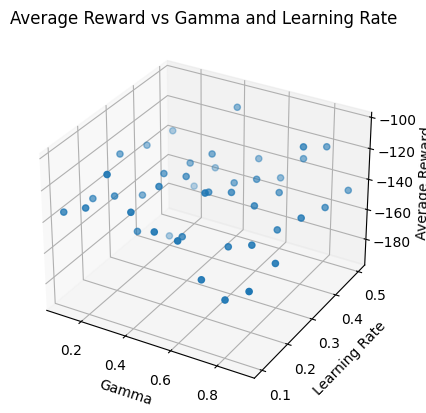

In [67]:
import matplotlib.pyplot as plt

# Extract the gamma values, learning rate values, and average rewards from the results
gamma_values = [result['gamma'] for result in results]
learning_rate_values = [result['learning_rate'] for result in results]
average_rewards = [result['average_reward'] for result in results]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gamma_values, learning_rate_values, average_rewards)

# Set labels and title
ax.set_xlabel('Gamma')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Average Reward')
ax.set_title('Average Reward vs Gamma and Learning Rate')

# Show the plot
plt.show()
